In [31]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/kdd-cup-1999-data/kddcup.data.gz
/kaggle/input/kdd-cup-1999-data/training_attack_types
/kaggle/input/kdd-cup-1999-data/kddcup.data.corrected
/kaggle/input/kdd-cup-1999-data/kddcup.newtestdata_10_percent_unlabeled.gz
/kaggle/input/kdd-cup-1999-data/kddcup.testdata.unlabeled.gz
/kaggle/input/kdd-cup-1999-data/corrected.gz
/kaggle/input/kdd-cup-1999-data/kddcup.data_10_percent.gz
/kaggle/input/kdd-cup-1999-data/kddcup.names
/kaggle/input/kdd-cup-1999-data/kddcup.data_10_percent_corrected
/kaggle/input/kdd-cup-1999-data/typo-correction.txt
/kaggle/input/kdd-cup-1999-data/kddcup.testdata.unlabeled_10_percent.gz
/kaggle/input/kdd-cup-1999-data/kddcup.data/kddcup.data
/kaggle/input/kdd-cup-1999-data/kddcup.testdata.unlabeled/kddcup.testdata.unlabeled
/kaggle/input/kdd-cup-1999-data/corrected/corrected
/kaggle/input/kdd-cup-1999-data/kddcup.testdata.unlabeled_10_percent/kddcup.testdata.unlabeled_10_percent
/kaggle/input/kdd-cup-1999-data/kddcup.newtestdata_10_percent_unlabeled/kd

**Importing Libraries**

In [32]:
# Import system packages
import os
import sys
import time
import logging
import importlib

#Import data manipulation libraries
import pandas as pd #for data manipulation and analysis, mainly with dataframes
import numpy as np #useful for numerical operations and handling arrays
import collections
from tqdm import tqdm


from sklearn.preprocessing import LabelEncoder  #to convert categorical labels into numerical values.
import argparse #for handling command-line arguments.

#Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

#Importing ML/DL libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc,precision_recall_fscore_support, average_precision_score
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix,accuracy_score

import tensorflow as tf
from tensorflow import keras
# from tensorflow.keras import layer

from tensorflow.keras import initializers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Input, BatchNormalization, LeakyReLU, Dense, Reshape, Flatten, Activation 
from tensorflow.keras.layers import Dropout, multiply, GaussianNoise, MaxPooling2D, concatenate
import pickle

import random
random.seed(123)


**Setting up Argument Parsing**

In [33]:
# Check if running in a Jupyter notebook environment
if 'ipykernel' in sys.modules:
    # Set pct_anomalies manually in Jupyter environment
    pct_anomalies = 0.01
else:
    # Command-line argument parsing
    parser = argparse.ArgumentParser() #Initializes the argument parser.
    parser.add_argument('--pct_anomalies', default=.01, type=float) #Adds an argument for specifying the percentage of anomalies to keep. The default value is 1% (.01), and it's parsed as a float.
    args = parser.parse_args() #Parses the arguments passed from the command line.
    pct_anomalies = args.pct_anomalies #Stores the value of pct_anomalies in a variable for later use.

**Loading Data**

In [34]:
data_path = '/kaggle/input/kdd-cup-1999-data/kddcup.data.corrected' #Specifies the path to the dataset.

col_names = ["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins","logged_in",
             "num_compromised","root_shell","su_attempted","num_root","num_file_creations","num_shells","num_access_files","num_outbound_cmds",
             "is_host_login","is_guest_login","count","srv_count","serror_rate","srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
             "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate","dst_host_diff_srv_rate",
             "dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate","dst_host_rerror_rate",
             "dst_host_srv_rerror_rate","label"]


df = pd.read_csv(data_path,names=col_names, index_col=False) #Reads the dataset from the CSV file into a pandas DataFrame df

**Explore the Data**

In [35]:
df.head(5)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,215,45076,0,0,0,0,...,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,162,4528,0,0,0,0,...,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,236,1228,0,0,0,0,...,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,233,2032,0,0,0,0,...,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,239,486,0,0,0,0,...,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,normal.


In [36]:
df.dtypes

duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate          

In [37]:
df.isnull().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

In [38]:
df.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,...,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06
mean,4.834243e+01,1.834621e+03,1.093623e+03,5.716116e-06,6.487792e-04,7.961733e-06,1.243766e-02,3.205108e-05,1.435290e-01,8.088304e-03,...,2.329811e+02,1.892142e+02,7.537132e-01,3.071111e-02,6.050520e-01,6.464107e-03,1.780911e-01,1.778859e-01,5.792780e-02,5.765941e-02
std,7.233298e+02,9.414311e+05,6.450123e+05,2.390833e-03,4.285434e-02,7.215084e-03,4.689782e-01,7.299408e-03,3.506116e-01,3.856481e+00,...,6.402094e+01,1.059128e+02,4.111860e-01,1.085432e-01,4.809877e-01,4.125978e-02,3.818382e-01,3.821774e-01,2.309428e-01,2.309777e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,4.500000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.550000e+02,4.900000e+01,4.100000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,5.200000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.550000e+02,2.550000e+02,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,1.032000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.550000e+02,2.550000e+02,1.000000e+00,4.000000e-02,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,5.832900e+04,1.379964e+09,1.309937e+09,1.000000e+00,3.000000e+00,1.400000e+01,7.700000e+01,5.000000e+00,1.000000e+00,7.479000e+03,...,2.550000e+02,2.550000e+02,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


**Target Distribution**

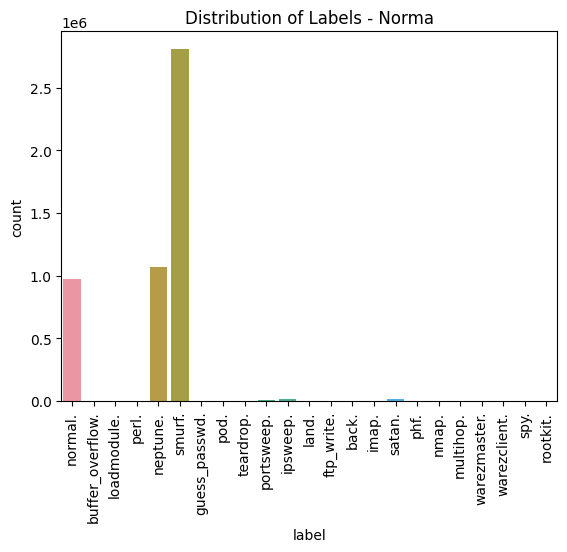

In [39]:
# Check the distribution of the target variable (e.g., normal vs anomaly)
sns.countplot(data=df, x='label')
plt.xticks(rotation=90)
plt.title('Distribution of Labels - Norma')
plt.show()

Imbalanced Dataset: The dataset is heavily imbalanced. Certain attack types, like "smurf" and "neptune," dominate the dataset. These two types are represented by the tallest bars and seem to far outnumber other types of attacks and normal instances.

Minority Classes: Several attack types (like "buffer_overflow", "teardrop", "ipsweep", etc.) have very few instances. These minority classes might be underrepresented, which could pose challenges during model training as the model may not learn to detect these attacks well.

Normal Instances: The number of "normal" instances (shown on the left side) is also quite substantial but significantly smaller than the top attack types (e.g., "smurf" and "neptune").

**Visualise Other Categorical Variables Distribution**

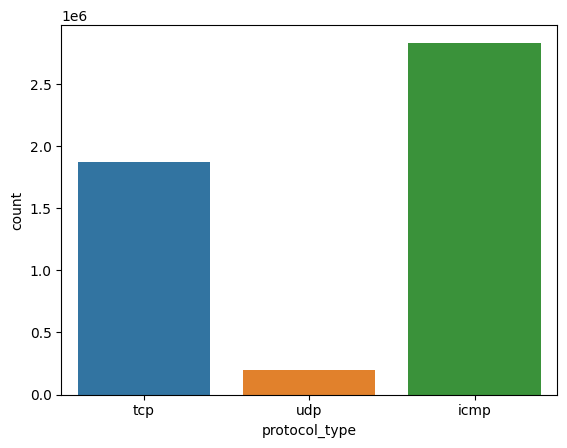

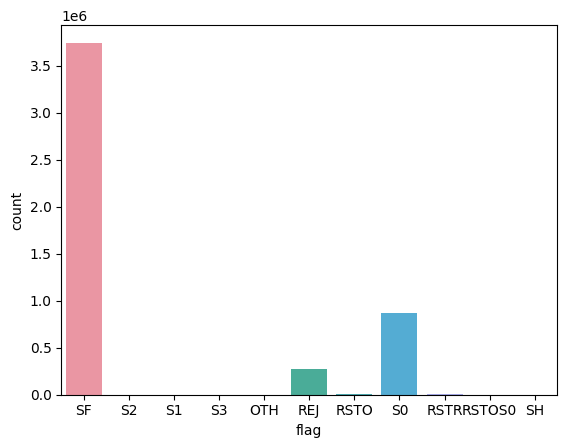

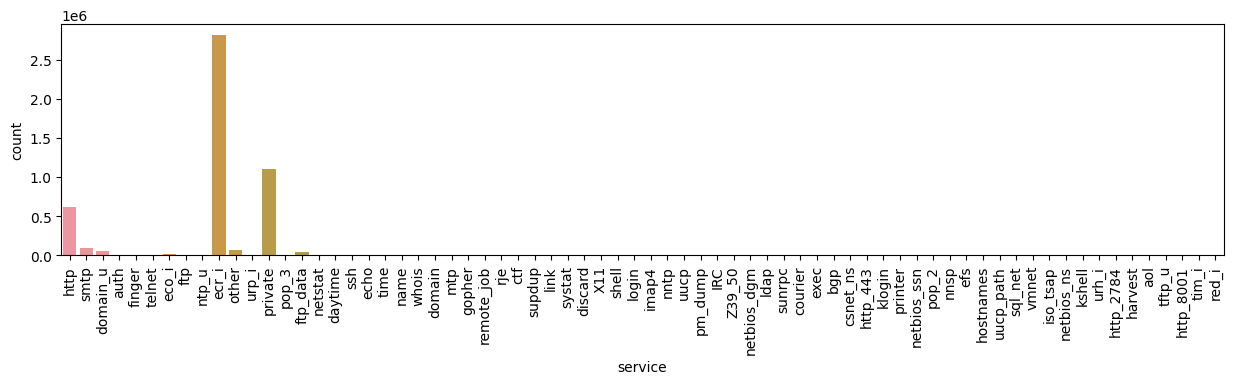

In [40]:
# Visualize categorical variable distributions
sns.countplot(data=df, x='protocol_type')
plt.show()

sns.countplot(data=df, x='flag')
plt.show()

plt.figure(figsize=(15,3))
sns.countplot(data=df, x='service')
plt.xticks(rotation=90)
plt.show()

**Label Encoding**

In [41]:
le = LabelEncoder()
le.fit(df.label)


LabelEncoder()

**One-Hot Encoding for Categorical Variables**

In [42]:
# capture the categorical variables and one-hot encode them
cat_vars = ['protocol_type', 'service', 'flag', 'land', 'logged_in','is_host_login', 'is_guest_login']

**Separating Numeric and Categorical Data**

In [43]:
# find unique labels for each category
cat_data = pd.get_dummies(df[cat_vars])

numeric_vars = list(set(df.columns.values.tolist()) - set(cat_vars))
numeric_vars.remove('label')
numeric_data = df[numeric_vars].copy()

numeric_cat_data = pd.concat([numeric_data, cat_data], axis=1)

**Label Transformation**

In [44]:
labels = df['label'].copy()
integer_labels = le.transform(labels)

**Splitting Data into Training and Test Sets**

In [45]:
x_train, x_test, y_train, y_test = train_test_split(numeric_cat_data,
                                                    integer_labels,
                                                    test_size=.25, 
                                                    random_state=42)

In [46]:
np.unique(y_train)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22])

**Convert Labels to Binary**

In [47]:
#Obtain the class number for Normal entries 
pd.DataFrame(le.classes_, columns = ['Type'])

,Type
0,back.
1,buffer_overflow.
2,ftp_write.
3,guess_passwd.
4,imap.
5,ipsweep.
6,land.
7,loadmodule.
8,multihop.
9,neptune.


In [48]:
# Converting labels to Binary

y_test[y_test != 5] = 1 
y_test[y_test == 5] = 0
y_train[y_train != 5] = 1
y_train[y_train == 5] = 0

We will now split the dataset into normal and anomalous data. We will need to do this in order to be able to train GANs to generate Normal packets only and then predict the anomaly based on the Discriminator output.

In [49]:
#Subsetting only Normal Network packets in our training set

temp_df = x_train.copy()
temp_df['label'] = y_train
temp_df = temp_df.loc[temp_df['label'] == 0]
temp_df = temp_df.drop('label', axis = 1)
x_train = temp_df.copy()

In [50]:
# Normalize the above splits using the MinMaxScaler from the scikit learn package
scaler = MinMaxScaler()

# Make sure to only fit the scaler on the training data
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

#Creating dataset dictionary 
dataset = {}
dataset['x_train'] = x_train.astype(np.float32)
dataset['y_train'] = y_train.astype(np.float32)
dataset['x_test']  = x_test.astype(np.float32)
dataset['y_test']  = y_test.astype(np.float32)

The Testing set comprises a small number of anomalous network packets of about 1%, reflecting what we see in the real world.

The Training set consists of only normal network packets.


**AutoEncoder**

In [51]:
# data dimensions // hyperparameters 
input_dim = x_train.shape[1]
BATCH_SIZE = 256
EPOCHS = 100

# https://keras.io/layers/core/
autoencoder = tf.keras.models.Sequential([
    
    # deconstruct / encode
    tf.keras.layers.Dense(input_dim, activation='elu', input_shape=(input_dim, )), 
    tf.keras.layers.Dense(16, activation='elu'),
    tf.keras.layers.Dense(8, activation='elu'),
    tf.keras.layers.Dense(4, activation='elu'),
    tf.keras.layers.Dense(2, activation='elu'),
    
    # reconstruction / decode
    tf.keras.layers.Dense(4, activation='elu'),
    tf.keras.layers.Dense(8, activation='elu'),
    tf.keras.layers.Dense(16, activation='elu'),
    tf.keras.layers.Dense(input_dim, activation='elu')
    
])


autoencoder.compile(optimizer="adam", 
                    loss="binary_crossentropy",
                    metrics=["acc"])

# print an overview of our model
autoencoder.summary();


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 122)            │        15,006 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │         1,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 2)              │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 4)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 122)            │         2,074 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,426 (75.88 KB)

 Trainable params: 19,426 (75.88 KB)

 Non-trainable params: 0 (0.00 B)

**Train the model**

In [52]:
autoencoder.fit(x_train, x_train,  # Use x_train as both input and output
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))  # Use x_test as both input and output

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 14s 299ms/step - acc: 0.0000e+00 - loss: 0.6361 - val_acc: 2.2864e-05 - val_loss: 3.7480
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 171ms/step - acc: 0.0000e+00 - loss: 0.4875 - val_acc: 2.6131e-05 - val_loss: 3.6867
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 179ms/step - acc: 0.0000e+00 - loss: 0.4654 - val_acc: 2.6131e-05 - val_loss: 1.9678
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 172ms/step - acc: 0.0000e+00 - loss: 0.4470 - val_acc: 2.6947e-05 - val_loss: 2.0254
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 171ms/step - acc: 0.0000e+00 - loss: 0.4291 - val_acc: 2.4498e-05 - val_loss: 2.2268
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 170ms/step - acc: 0.0000e+00 - loss: 0.4169 - val_acc: 2.5314e-05 - val_loss: 2.2759
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 168ms/step - acc: 0.0000e+00 - loss: 0.4017 - val_acc: 2.6131e-05 - val_loss: 4.0075
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 176ms/step - acc: 0.0015 - loss: 0.2900 - val_acc: 0.0074 - val_loss: 4.0111

**Anomaly Prediction**

In [53]:
# Set a threshold for anomaly detection
mean_loss = np.mean(reconstruction_loss)
std_loss = np.std(reconstruction_loss)
threshold = mean_loss + 2 * std_loss  

# Identify anomalies based on reconstruction loss
predicted_labels = (reconstruction_loss > threshold).astype(int)

In [57]:
print(f"Reconstruction Loss Threshold: {threshold:.4f}")
print(f"Number of anomalies detected: {np.sum(anomalies)} out of {len(anomalies)} samples")
anomaly_indices = np.where(anomalies)[0]
print("Anomaly indices:", anomaly_indices)

Reconstruction Loss Threshold: 3120940.4408
Number of anomalies detected: 3 out of 1224608 samples
Anomaly indices: [ 132040 1097781 1130892]


**Model Evaluation**

In [58]:
precision, recall, f1,_ = precision_recall_fscore_support(y_test,predicted_labels,average='binary')
print ('Accuracy Score :',accuracy_score(y_test, predicted_labels) )
print ('Precision :',precision )
print ('Recall :',recall )
print ('F1 :',f1 )

Accuracy Score : 0.002560002874389192
Precision : 1.0
Recall : 2.4560449816451573e-06
F1 : 4.912077899006041e-06


**Classification Report**

In [63]:
from sklearn.metrics import confusion_matrix, classification_report
class_report = classification_report(y_test, predicted_labels)
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

           0       0.00      1.00      0.01      3132
           1       1.00      0.00      0.00   1221476

    accuracy                           0.00   1224608
   macro avg       0.50      0.50      0.00   1224608
weighted avg       1.00      0.00      0.00   1224608



**Confusion Matrix**

Confusion Matrix :


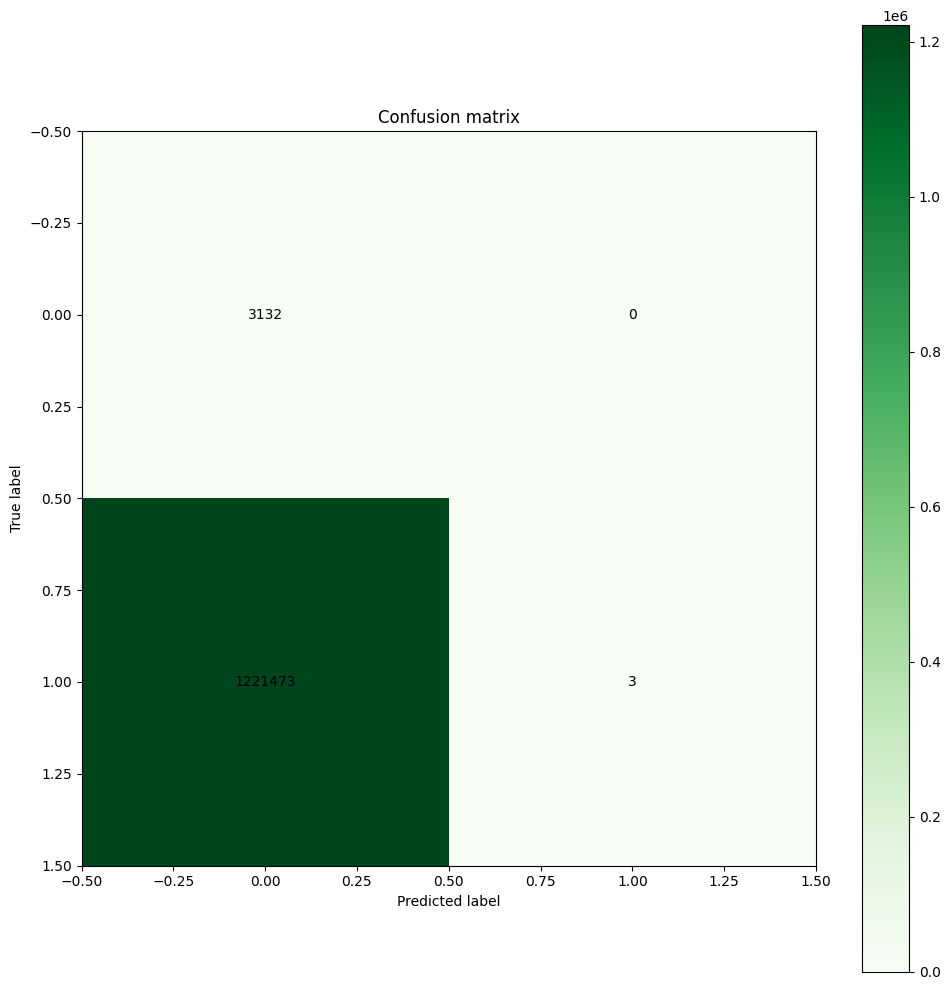

In [64]:
cm = confusion_matrix(y_test, predicted_labels)

print ('Confusion Matrix :')

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Greens):
    plt.figure(figsize=(10,10),)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()

    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


plot_confusion_matrix(cm)

**ROC Curve**

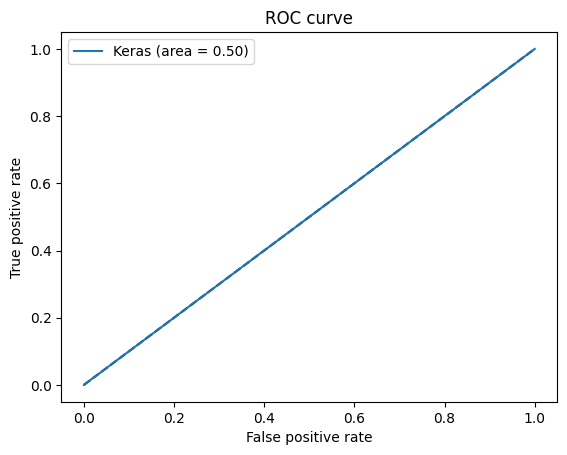

In [65]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, predicted_labels)
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.2f})'.format(auc_keras))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()